In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/fast_ds/thesis/experimentation/Segmentation/modification_testing
!ls

Mounted at /content/gdrive
/content/gdrive/My Drive/fast_ds/thesis/experimentation/Segmentation/modification_testing
ResUNetplusplus


In [2]:
%cd ./ResUNetplusplus
!ls 

/content/gdrive/My Drive/fast_ds/thesis/experimentation/Segmentation/modification_testing/ResUNetplusplus
'=1.0.7,'			       parameter_tuning.py
 bagging_approach.py		       process_image_deployment.py
 bagging_training_seed_old.py	       process_image.py
 bagging_training_seed.py	       process_image_sample.py
 boostrapping_images.ipynb	       process_image_tuning.py
 callbacks.py			       __pycache__
'Copy of execution_script.ipynb'       README.md
'Copy of TPU_execution_script.ipynb'   result
 data				       results.png
 data_generator.py		       resume_training.py
 deployment_model.py		       Resunet++.png
 execution_script.ipynb		       resunet_pp_modified.py
 files				       resunet.py
 files_before_tpu		       run_miouTesting.py
 files_kvasir_seg		       run_modified.py
 frozen_models			       run.py
 GFLOPs.ipynb			       run_sample.py
 hyperparameter_tuning.ipynb	       script_for_rafae.ipynb
 image_stiching.ipynb		       segmentation_metrics.py
 inference_script_cvc.ipynb	   

In [ ]:
%%writefile weighted_hausdorff_loss.py
import math

import numpy as np
import tensorflow as tf
from sklearn.utils.extmath import cartesian

resized_height = 144  
resized_width  = 256
max_dist = math.sqrt(resized_height**2 + resized_width**2)
n_pixels = resized_height * resized_width
all_img_locations = tf.convert_to_tensor(cartesian([np.arange(resized_height), np.arange(resized_width)]),
                                                   tf.float32)


def tf_repeat(tensor, repeats):
    """
    Args:
    input: A Tensor. 1-D or higher.
    repeats: A list. Number of repeat for each dimension, length must be the same as the number of dimensions in input
    Returns:
    
    A Tensor. Has the same type as input. Has the shape of tensor.shape * repeats
    """
    with tf.variable_scope("repeat"):
        expanded_tensor = tf.expand_dims(tensor, -1)
        multiples = [1] + repeats
        tiled_tensor = tf.tile(expanded_tensor, multiples = multiples)
        repeated_tesnor = tf.reshape(tiled_tensor, tf.shape(tensor) * repeats)
    return repeated_tesnor



def Weighted_Hausdorff_loss(y_true, y_pred):
    # https://arxiv.org/pdf/1806.07564.pdf
    #prob_map_b - y_pred
    #gt_b - y_true

    terms_1 = []
    terms_2 = []
    y_true = tf.squeeze(y_true, axis=-1)
    y_pred = tf.squeeze(y_pred, axis=-1)
#     y_true = tf.reduce_mean(y_true, axis=-1)
#     y_pred = tf.reduce_mean(y_pred, axis=-1)
    for b in range(batch_size):
        gt_b = y_true[b]
        prob_map_b = y_pred[b]
        # Pairwise distances between all possible locations and the GTed locations
        n_gt_pts = tf.reduce_sum(gt_b)
        gt_b = tf.where(tf.cast(gt_b, tf.bool))
        gt_b = tf.cast(gt_b, tf.float32)
        d_matrix = tf.sqrt(tf.maximum(tf.reshape(tf.reduce_sum(gt_b*gt_b, axis=1), (-1, 1)) + tf.reduce_sum(all_img_locations*all_img_locations, axis=1)-2*(tf.matmul(gt_b, tf.transpose(all_img_locations))), 0.0))
        d_matrix = tf.transpose(d_matrix)
        # Reshape probability map as a long column vector,
        # and prepare it for multiplication
        p = tf.reshape(prob_map_b, (n_pixels, 1))
        n_est_pts = tf.reduce_sum(p)
        p_replicated = tf_repeat(tf.reshape(p, (-1, 1)), [1, n_gt_pts])
        eps = 1e-6
        alpha = 4
        # Weighted Hausdorff Distance
        term_1 = (1 / (n_est_pts + eps)) * tf.reduce_sum(p * tf.reshape(tf.reduce_min(d_matrix, axis=1), (-1, 1)))
        d_div_p = tf.reduce_min((d_matrix + eps) / (p_replicated**alpha + eps / max_dist), axis=0)
        d_div_p = tf.clip_by_value(d_div_p, 0, max_dist)
        term_2 = tf.reduce_mean(d_div_p, axis=0)
        terms_1.append(term_1)
        terms_2.append(term_2)
    terms_1 = tf.stack(terms_1)
    terms_2 = tf.stack(terms_2)
    terms_1 = tf.Print(tf.reduce_mean(terms_1), [tf.reduce_mean(terms_1)], "term 1")
    terms_2 = tf.Print(tf.reduce_mean(terms_2), [tf.reduce_mean(terms_2)], "term 2")
    res = terms_1 + terms_2
    return res

Overwriting weighted_hausdorff_loss.py


In [ ]:
## GFLOPs
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
from data_generator import *
from metrics import dice_coef, dice_loss, miou_coef, miou_loss
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from tensorflow.keras.optimizers import Adam, Nadam, SGD , RMSprop

def get_flops(model_h5_path):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()


    with graph.as_default():
      with session.as_default():
        ## Added for '<' not supported between instances of 'function' and 'str'
        lr = 1e-4
        optimizer = Nadam(lr)
        metrics = [Recall(), Precision(), dice_coef, MeanIoU(num_classes=2),miou_coef]
        with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
          model = load_model(model_path)

      
      model.compile(loss=miou_loss, optimizer=optimizer, metrics=metrics)
      print("model compiled successfully")
        # model = tf.keras.models.load_model(model_h5_path)

      run_meta = tf.compat.v1.RunMetadata()
      opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

      # Optional: save printed results to file
      # flops_log_path = os.path.join(tempfile.gettempdir(), 'tf_flops_log.txt')
      # opts['output'] = 'file:outfile={}'.format(flops_log_path)

      # We use the Keras session graph in the call to the profiler.
      flops = tf.compat.v1.profiler.profile(graph=graph,
                                            run_meta=run_meta, cmd='op', options=opts)
      print(model.summary())
      return flops.total_float_ops

In [ ]:
tf.__version__

NameError: ignored

In [ ]:
%%writefile segmentation_metrics.py

import numbers

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops, math_ops, nn_ops, standard_ops

# from tensorlayer import logging

def dice_coe(output, target, loss_type='jaccard', axis=(1, 2, 3), smooth=1e-5):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity
    of two batch of data, usually be used for binary image segmentation
    i.e. labels are binary. The coefficient between 0 to 1, 1 means totally match.

    Parameters
    -----------
    output : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    target : Tensor
        The target distribution, format the same with `output`.
    loss_type : str
        ``jaccard`` or ``sorensen``, default is ``jaccard``.
    axis : tuple of int
        All dimensions are reduced, default ``[1,2,3]``.
    smooth : float
        This small value will be added to the numerator and denominator.
            - If both output and target are empty, it makes sure dice is 1.
            - If either output or target are empty (all pixels are background), dice = ```smooth/(small_value + smooth)``, then if smooth is very small, dice close to 0 (even the image values lower than the threshold), so in this case, higher smooth can have a higher dice.

    Examples
    ---------
    >>> import tensorlayer as tl
    >>> outputs = tl.act.pixel_wise_softmax(outputs)
    >>> dice_loss = 1 - tl.cost.dice_coe(outputs, y_)

    References
    -----------
    - `Wiki-Dice <https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient>`__

    """
    inse = tf.reduce_sum(output * target, axis=axis)
    if loss_type == 'jaccard':
        l = tf.reduce_sum(output * output, axis=axis)
        r = tf.reduce_sum(target * target, axis=axis)
    elif loss_type == 'sorensen':
        l = tf.reduce_sum(output, axis=axis)
        r = tf.reduce_sum(target, axis=axis)
    else:
        raise Exception("Unknow loss_type")
    # old axis=[0,1,2,3]
    # dice = 2 * (inse) / (l + r)
    # epsilon = 1e-5
    # dice = tf.clip_by_value(dice, 0, 1.0-epsilon) # if all empty, dice = 1
    # new haodong
    dice = (2. * inse + smooth) / (l + r + smooth)
    ##
    dice = tf.reduce_mean(dice, name='dice_coe')
    return dice



def dice_hard_coe(output, target, threshold=0.5, axis=(1, 2, 3), smooth=1e-5):
    """Non-differentiable Sørensen–Dice coefficient for comparing the similarity
    of two batch of data, usually be used for binary image segmentation i.e. labels are binary.
    The coefficient between 0 to 1, 1 if totally match.

    Parameters
    -----------
    output : tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    target : tensor
        The target distribution, format the same with `output`.
    threshold : float
        The threshold value to be true.
    axis : tuple of integer
        All dimensions are reduced, default ``(1,2,3)``.
    smooth : float
        This small value will be added to the numerator and denominator, see ``dice_coe``.

    References
    -----------
    - `Wiki-Dice <https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient>`__

    """
    output = tf.cast(output > threshold, dtype=tf.float32)
    target = tf.cast(target > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(output, target), axis=axis)
    l = tf.reduce_sum(output, axis=axis)
    r = tf.reduce_sum(target, axis=axis)
    # old axis=[0,1,2,3]
    # hard_dice = 2 * (inse) / (l + r)
    # epsilon = 1e-5
    # hard_dice = tf.clip_by_value(hard_dice, 0, 1.0-epsilon)
    # new haodong
    hard_dice = (2. * inse + smooth) / (l + r + smooth)
    ##
    hard_dice = tf.reduce_mean(hard_dice, name='hard_dice')
    return hard_dice



def iou_coe(output, target, threshold=0.5, axis=(1, 2, 3), smooth=1e-5):
    """Non-differentiable Intersection over Union (IoU) for comparing the
    similarity of two batch of data, usually be used for evaluating binary image segmentation.
    The coefficient between 0 to 1, and 1 means totally match.

    Parameters
    -----------
    output : tensor
        A batch of distribution with shape: [batch_size, ....], (any dimensions).
    target : tensor
        The target distribution, format the same with `output`.
    threshold : float
        The threshold value to be true.
    axis : tuple of integer
        All dimensions are reduced, default ``(1,2,3)``.
    smooth : float
        This small value will be added to the numerator and denominator, see ``dice_coe``.

    Notes
    ------
    - IoU cannot be used as training loss, people usually use dice coefficient for training, IoU and hard-dice for evaluating.

    """
    pre = tf.cast(output > threshold, dtype=tf.float32)
    truth = tf.cast(target > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(pre, truth), axis=axis)  # AND
    union = tf.reduce_sum(tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32), axis=axis)  # OR
    # old axis=[0,1,2,3]
    # epsilon = 1e-5
    # batch_iou = inse / (union + epsilon)
    # new haodong
    batch_iou = (inse + smooth) / (union + smooth)
    iou = tf.reduce_mean(batch_iou, name='iou_coe')
    return iou  # , pre, truth, inse, union

Overwriting segmentation_metrics.py


In [ ]:
# model_path = "files/daspp_relu_miou.h5" get_flops = 30074652
# model_path = "files/daspp_miou.h5" get_flops = 40099550
# model_path = "files/miou.h5" get_flops = 8718068
model_path = "files/models/unet_miou_2.h5"


In [ ]:
get_flops(model_path)

In [ ]:
# !pip3 install keras-flops

In [ ]:
# resunetpp_cvc_png
# %pycat infer_parameters.py
!python3 infer_parameters.py "files/models/resunetpp_cvc_png.h5"

2021-05-29 15:32:46.689939: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
infer_parameters.py
files/models/resunetpp_cvc_png.h5
2021-05-29 15:32:54.460880: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-05-29 15:32:54.540184: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-29 15:32:54.540244: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5e929685c724): /proc/driver/nvidia/version does not exist
model compiled successfully
Test Result: 
60
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings

In [ ]:
# sepv_conv_cvc_png
# %pycat infer_parameters.py
!python3 infer_parameters.py "files/models/sepv_conv_cvc_png.h5"

2021-05-29 15:34:03.027475: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
infer_parameters.py
files/models/sepv_conv_cvc_png.h5
2021-05-29 15:34:05.148189: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-05-29 15:34:05.162881: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-29 15:34:05.162945: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5e929685c724): /proc/driver/nvidia/version does not exist
model compiled successfully
Test Result: 
60
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings

In [ ]:
# sepv_conv_cvc
# %pycat infer_parameters.py
!python3 infer_parameters.py "files/models/sepv_conv_cvc.h5"

2021-05-04 05:21:33.713950: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
infer_parameters.py
files/models/sepv_conv_cvc.h5
2021-05-04 05:21:42.436608: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-04 05:21:42.438317: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-04 05:21:42.450362: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-04 05:21:42.450437: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (239fd371b253): /proc/driver/nvidia/version does not exist
2021-05-04 05:21:42.451254: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
model compiled successfull

In [ ]:
# daspp
# %pycat infer_parameters.py
!python3 infer_parameters.py "files/models/daspp_cvc.h5"

2021-05-04 05:23:36.661117: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
infer_parameters.py
files/models/daspp_cvc.h5
2021-05-04 05:23:39.794262: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-04 05:23:39.796095: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-04 05:23:39.818945: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-04 05:23:39.819035: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (239fd371b253): /proc/driver/nvidia/version does not exist
2021-05-04 05:23:39.819676: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
model compiled successfully
Te

In [ ]:
# unet_dice_cvc
# %pycat infer_parameters.py
!python3 infer_parameters.py "files/models/unet_dice_cvc.h5"

2021-05-08 13:15:50.991858: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
infer_parameters.py
files/models/unet_dice_cvc.h5
2021-05-08 13:15:59.213302: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-08 13:15:59.245290: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-08 13:15:59.324909: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-08 13:15:59.325014: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6a488b298ffb): /proc/driver/nvidia/version does not exist
2021-05-08 13:15:59.325682: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
model compiled successfull

In [ ]:
# unet
# %pycat infer_parameters.py
!python3 infer_parameters.py "files/models/unet_cvc.h5"

2021-05-04 05:24:40.146562: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
infer_parameters.py
files/models/unet_cvc.h5
2021-05-04 05:24:43.035274: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-04 05:24:43.036353: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-04 05:24:43.048646: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-04 05:24:43.048718: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (239fd371b253): /proc/driver/nvidia/version does not exist
2021-05-04 05:24:43.049305: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
model compiled successfully
Tes

In [ ]:
# resunet
# %pycat infer_parameters.py
!python3 infer_parameters.py "files/models/resunet_cvc.h5"

2021-05-04 05:25:12.974516: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
infer_parameters.py
files/models/resunet_cvc.h5
2021-05-04 05:25:15.908306: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-04 05:25:15.909352: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-04 05:25:15.921246: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-04 05:25:15.921302: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (239fd371b253): /proc/driver/nvidia/version does not exist
2021-05-04 05:25:15.921873: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
model compiled successfully


In [ ]:
## Submission 

import os
import time
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
from tensorflow.keras.utils import CustomObjectScope
from metrics import dice_coef, dice_loss, miou_coef, miou_loss


# Set path to test dataset
# TEST_DATASET_PATH = "./test_images"
TEST_DATASET_PATH = "new_data/CVC-ClinicDB/test/images"
# MASK_PATH = "./mask"
MASK_PATH = "new_data/CVC-ClinicDB/test/predict_masks"
model_path = "files/models/sepv_conv_cvc.h5"

# Load Keras model
# model = tf.keras.models.load_model("../files/daspp_relu_deployment.h5")
with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  # model = tf.keras.models.load_model("../files/daspp_miou.h5")
  model = tf.keras.models.load_model(model_path)

time_taken = []
for image_name in os.listdir(TEST_DATASET_PATH):

    # Load the test image
    image_path = os.path.join(TEST_DATASET_PATH, image_name)
    image = cv2.imread(image_path)
    H, W, _ = image.shape
    image = cv2.resize(image, (256, 256))
    image = np.expand_dims(image, axis=0)

    # Start time
    start_time = time.time()

    ## Prediction
    mask = model.predict(image)[0]

    # End timer
    end_time = time.time() - start_time

    time_taken.append(end_time)
    print("{} - {:.10f}".format(image_name, end_time))

    mask = mask > 0.5
    mask = mask.astype(np.float32)
    mask = mask * 255.0
    mask = cv2.resize(mask, (H, W))

    mask_path = os.path.join(MASK_PATH, image_name)
    cv2.imwrite(mask_path, mask)

mean_time_taken = np.mean(time_taken)
mean_fps = 1/mean_time_taken
print("Mean FPS: ", mean_fps)


199.jpg - 1.9015452862
477.jpg - 0.7807953358
68.jpg - 0.7746839523
169.jpg - 0.7805922031
262.jpg - 0.7688100338
355.jpg - 0.7870104313
108.jpg - 0.7679314613
521.jpg - 0.7674124241
17.jpg - 0.7900578976
413.jpg - 0.7709856033
149.jpg - 0.7747483253
205.jpg - 0.7607109547
198.jpg - 0.7684040070
89.jpg - 0.7946259975
431.jpg - 0.7796423435
31.jpg - 0.7777941227
126.jpg - 0.7842586040
290.jpg - 0.7748429775
265.jpg - 0.7758343220
177.jpg - 0.7616355419
100.jpg - 0.7829124928
88.jpg - 0.7830431461
581.jpg - 0.7830138206
96.jpg - 0.7751340866
430.jpg - 0.7687985897
585.jpg - 0.7890589237
164.jpg - 0.7776007652
220.jpg - 0.7815475464
60.jpg - 0.7620272636
493.jpg - 0.7752513885
95.jpg - 0.7774779797
246.jpg - 0.7684271336
173.jpg - 0.7667229176
330.jpg - 0.7948100567
272.jpg - 0.7779626846
507.jpg - 0.7811615467
218.jpg - 0.7846658230
563.jpg - 0.7704515457
497.jpg - 0.7779130936
347.jpg - 0.7703483105
427.jpg - 0.7925858498
125.jpg - 0.7691011429
555.jpg - 0.7855460644
72.jpg - 0.78422164

In [ ]:
# !lscpu |grep 'Model name' # CPU Info
# !lscpu | grep 'Number of Socket(s):' # No. of Sockets
# !lscpu | grep 'Core(s) each processor has/per socket:' # cores per processor
# !lscpu | grep 'Number of threads/core:' # threads per core
# !lscpu | grep "Clock frequency in MHz:" # clock frequency
!!free -h --si | awk  '/Mem:/{print $2}' # memory allocation

['13G']

In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2300.000
BogoMIPS:            4600.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

In [ ]:
### Standalone mask evaluation

In [ ]:
import tensorflow as tf
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state([0, 0, 1, 1], [0, 1, 0, 1])
m.result().numpy()

0.33333334

In [ ]:
import cv2
import numpy as np
def parse_mask(mask_path, image_size):
    mask = cv2.imread(mask_path, -1)
    h, w = mask.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        mask = cv2.resize(mask, (image_size, image_size))
    mask = np.expand_dims(mask, -1)
    mask = mask/255.0

    return mask

In [ ]:
image_size = 256
a = parse_mask("new_data/Kvasir-SEG_overwritten/valid/masks/cju30525w04r10835ygp257sb.jpg", image_size)

In [ ]:
image_size = 256
b = parse_mask("new_data/Kvasir-SEG_overwritten/valid/masks/cju8418jhkf7d0818ga2v0xq0.jpg", image_size)

In [ ]:
image_size = 256
c = parse_mask("new_data/Kvasir-SEG_overwritten/valid/masks/cjyzkmjy8evns070165gf9dmq.jpg", image_size)

In [ ]:
import tensorflow as tf
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(a, b)
m.result().numpy()

0.42221203

In [ ]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(a, c)
m.result().numpy()

0.41619402

In [ ]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(b, c)
m.result().numpy()

0.43750158

In [ ]:
# from metrics import dice_coef, dice_loss, miou_coef, miou_loss
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def miou_coef(y_true, y_pred):
  y_true_f = tf.keras.layers.Flatten()(y_true)
  y_pred_f = tf.keras.layers.Flatten()(y_pred)
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)-intersection
  iou = (intersection + smooth) / (union + smooth)
  return iou

In [ ]:
smooth = 1.
d = list()
for i in range(2):
  if i == 0:
    d.append(dice_coef(a,b))
    print(dice_coef(a,b).numpy())
  else:
    d.append(dice_coef(a,c))

print(np.mean(d))

0.34710622
0.18602459


In [ ]:
smooth = 1.
miou_coef(a,b)

<tf.Tensor: shape=(), dtype=float32, numpy=0.21001343>

In [ ]:
x = parse_mask("new_data/Kvasir-SEG_overwritten/valid/masks/cju88l66no10s0850rsda7ej1.jpg", image_size) # large polyp
y = parse_mask("new_data/Kvasir-SEG_overwritten/valid/masks/cju87tyddnnad0755bj0wxahe.jpg", image_size) # large polyp
z = parse_mask("new_data/Kvasir-SEG_overwritten/valid/masks/cju87zv8lni0o0850hbbecbq6.jpg", image_size) # small polyp
z1 = parse_mask("new_data/Kvasir-SEG_overwritten/valid/masks/cju88cddensj00987788yotmg.jpg", image_size) # small polyp

In [ ]:
hard_prediction = np.ceil((np.ceil(x)+np.ceil(y)+np.ceil(z))/3)
cv2.imwrite("hard_prediction.png", hard_prediction)

True

In [ ]:
hard_prediction = (x+y+z)/3
cv2.imwrite("x.png", x)

True

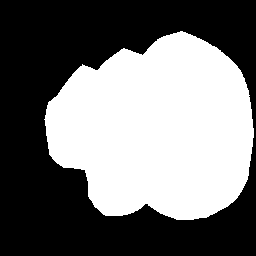

In [ ]:
# from google.colab.patches import cv2_imshow

# window_name = 'image'

cv2_imshow((np.round((x+y+z)/3, decimals = 0)*255.0)) 

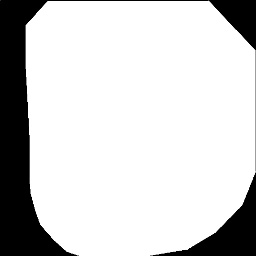

In [ ]:
cv2_imshow((x)*255)

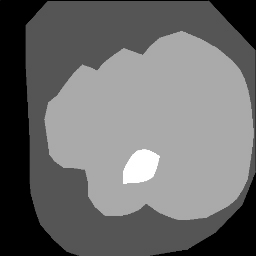

In [ ]:
cv2_imshow((((x+y+z)/3)*255)) 

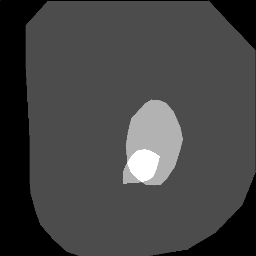

In [ ]:
cv2_imshow((np.round((x+z+z1)/3, decimals = 1)*255.0)) 

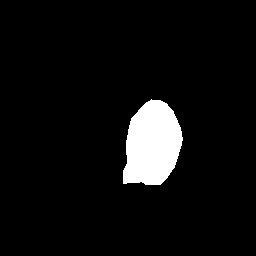

In [ ]:
cv2_imshow((np.round((x+z+z1)/3, decimals = 0)*255.0)) 

In [ ]:
smooth = 1.0
dice_coef(np.round((x+y+z)/3, decimals = 0),y) ## use np.round((x+y+z)/3, decimals = 0) to make hard voting prediction

<tf.Tensor: shape=(), dtype=float32, numpy=0.99815637>

In [ ]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(np.round((x+y+z)/3, decimals = 0), y)
m.result().numpy()

0.95671105

In [ ]:
### Bagging Approach

import os
import time
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
from tensorflow.keras.utils import CustomObjectScope
# from metrics import dice_coef, dice_loss, miou_coef, miou_loss
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from segmentation_metrics import dice_coe,dice_hard_coe,iou_coe

def parse_image(img_path, image_size):
    image_rgb = cv2.imread(img_path, 1)
    h, w, _ = image_rgb.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        image_rgb = cv2.resize(image_rgb, (image_size, image_size))
    image_rgb = image_rgb/255.0
    return image_rgb

def parse_mask(mask_path, image_size):
    mask = cv2.imread(mask_path, -1)
    h, w = mask.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        mask = cv2.resize(mask, (image_size, image_size))
    mask = np.expand_dims(mask, -1)
    mask = mask/255.0

    return mask

# from metrics import dice_coef, dice_loss, miou_coef, miou_loss
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def miou_coef(y_true, y_pred):
  y_true_f = tf.keras.layers.Flatten()(y_true)
  y_pred_f = tf.keras.layers.Flatten()(y_pred)
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)-intersection
  iou = (intersection + smooth) / (union + smooth)
  return iou

def miou_loss(y_true, y_pred):
    return 1.0 - miou_coef(y_true, y_pred)


# Set path to test dataset
# TEST_DATASET_PATH = "./test_images"
TEST_DATASET_PATH = "new_data/CVC-ClinicDB/test/images"
GROUND_TRUTH_PATH = "new_data/CVC-ClinicDB/test/masks/"
# MASK_PATH = "./mask"
MASK_PATH = "new_data/CVC-ClinicDB/test/predict_masks"
model_path = "files_before_tpu/miou.h5"

# Load Keras model
with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  resunet_cvc = tf.keras.models.load_model("files/models/resunet_cvc.h5")

with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  sepv_conv_cvc = tf.keras.models.load_model("files/models/sepv_conv_cvc.h5")

with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  daspp_cvc = tf.keras.models.load_model("files/models/daspp_cvc.h5")

time_taken = []
precision = Precision()
recall = Recall()
mean_io_u = MeanIoU(num_classes=2)
smooth = 1.
image_size = 256
# jaccard = miou_coef()
f1 = list()

for image_name in os.listdir(TEST_DATASET_PATH):

    # Load the test image
    image_path = os.path.join(TEST_DATASET_PATH, image_name)
    image = cv2.imread(image_path)
    H, W, _ = image.shape
    image = cv2.resize(image, (256, 256))
    image = np.expand_dims(image, axis=0)

    # Start time
    start_time = time.time()

    ## Prediction
    mask1 = resunet_cvc.predict(image)[0]
    mask2 = sepv_conv_cvc.predict(image)[0]
    mask3 = daspp_cvc.predict(image)[0]

    # End timer
    end_time = time.time() - start_time

    time_taken.append(end_time)
    print("**********************************************************")
    # print(GROUND_TRUTH_PATH + image_name)
    ground_truth_mask = parse_mask(GROUND_TRUTH_PATH + image_name, image_size)
    print("{} - {:.10f}".format(image_name, end_time))

    # # mask1 = mask1 > 0.5
    # mask1 = mask1.astype(np.float32)
    # # mask2 = mask2 > 0.5
    # mask2 = mask2.astype(np.float32)
    # # mask3 = mask3 > 0.5
    # mask3 = mask3.astype(np.float32)

    mask = np.round((mask1+mask2+mask3)/3, decimals = 0)
    mask = mask > 0.5
    mask = mask.astype(np.float32)
    f1.append(dice_coef(ground_truth_mask,mask).numpy())


    mask = mask * 255.0
    mask = cv2.resize(mask, (H, W))

    # mask_path = os.path.join(MASK_PATH, image_name)
    # cv2.imwrite(mask_path, mask)

mean_time_taken = np.mean(time_taken)
mean_fps = 1/mean_time_taken
print("******************************************")
print("Mean FPS: ", mean_fps)
print("Mean dice_coef: ", np.mean(f1))

**********************************************************
199.jpg - 6.0523779392
**********************************************************
477.jpg - 2.2961792946
**********************************************************
68.jpg - 2.3089966774
**********************************************************
169.jpg - 2.3261210918
**********************************************************
262.jpg - 2.3566877842
**********************************************************
355.jpg - 2.3669183254
**********************************************************
108.jpg - 2.3184032440
**********************************************************
521.jpg - 2.3408277035
**********************************************************
17.jpg - 2.3230190277
**********************************************************
413.jpg - 2.3540678024
**********************************************************
149.jpg - 2.3269727230
**********************************************************
205.jpg - 2.3513498306
******************

In [ ]:
TEST_DATASET_PATH

'new_data/Kvasir-SEG/test/images'

In [ ]:
from google.colab.patches import cv2_imshow

image_path = os.path.join(TEST_DATASET_PATH, 'ck2bxw18mmz1k0725litqq2mc.jpg')
image = cv2.imread(image_path)
H, W, _ = image.shape
image = cv2.resize(image, (256, 256))
image = np.expand_dims(image, axis=0)
# image = parse_image(image_path, 256)
print(image.shape[0])
cv2_imshow(image*255)

1


TypeError: ignored

In [ ]:
%%writefile bagging_approach.py
### Bagging Approach

## Load Module
import os
import time
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
from tensorflow.keras.utils import CustomObjectScope
# from metrics import dice_coef, dice_loss, miou_coef, miou_loss
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from segmentation_metrics import dice_coe,dice_hard_coe,iou_coe

## Define image parser
def parse_image(img_path, image_size):
    image_rgb = cv2.imread(img_path, 1)
    h, w, _ = image_rgb.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        image_rgb = cv2.resize(image_rgb, (image_size, image_size))
    image_rgb = image_rgb/255.0
    return image_rgb

def parse_mask(mask_path, image_size):
    mask = cv2.imread(mask_path, -1)
    h, w = mask.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        mask = cv2.resize(mask, (image_size, image_size))
    mask = np.expand_dims(mask, -1)
    mask = mask/255.0

    return mask

# from metrics import dice_coef, dice_loss, miou_coef, miou_loss
## define custom evaluation metrics
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def miou_coef(y_true, y_pred):
  y_true_f = tf.keras.layers.Flatten()(y_true)
  y_pred_f = tf.keras.layers.Flatten()(y_pred)
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)-intersection
  iou = (intersection + smooth) / (union + smooth)
  return iou

def miou_loss(y_true, y_pred):
    return 1.0 - miou_coef(y_true, y_pred)

def mask_to_3d(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask


# Set path to test dataset
# TEST_DATASET_PATH = "./test_images"
TEST_DATASET_PATH = "new_data/CVC-ClinicDB/test/images"
GROUND_TRUTH_PATH = "new_data/CVC-ClinicDB/test/masks/"
# MASK_PATH = "./mask"
PREDICTED_MASK_PATH = "new_data/CVC-ClinicDB/test/predicted_masks"
Results = "new_data/bagging_results"
model_path = "files_before_tpu/miou.h5"

# Load Keras model
with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  resunet_cvc = tf.keras.models.load_model("files/models/resunetpp_cvc_png.h5")

with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  sepv_conv_cvc = tf.keras.models.load_model("files/models/sepv_conv_cvc_png.h5")

with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  daspp_cvc = tf.keras.models.load_model("files/models/daspp_cvc.h5")

## List for each evaluation metrics
time_taken = []
precision = [] #Precision()
p = tf.keras.metrics.Precision()
recall = [] #Recall()
r = tf.keras.metrics.Recall()
mean_io_u = [] #MeanIoU(num_classes=2)
m = tf.keras.metrics.MeanIoU(num_classes=2)
smooth = 1.
image_size = 256
jaccard = list()
f1 = list()
loss = list()

## Loop over each images
for image_name in os.listdir(TEST_DATASET_PATH):

    # Load the test image
    image_path = os.path.join(TEST_DATASET_PATH, image_name)
    image = cv2.imread(image_path)
    H, W, _ = image.shape
    # image = cv2.resize(image, (256, 256))
    # image = np.expand_dims(image, axis=0)
    image = parse_image(image_path, 256)
    # print(image.shape)
    # print(np.expand_dims(image, axis=0).shape)

    # Start time
    start_time = time.time()

    ## Prediction
    mask1 = resunet_cvc.predict(np.expand_dims(image, axis=0))[0]
    mask2 = sepv_conv_cvc.predict(np.expand_dims(image, axis=0))[0]
    mask3 = daspp_cvc.predict(np.expand_dims(image, axis=0))[0]

    # End timer
    end_time = time.time() - start_time

    time_taken.append(end_time)
    print("**********************************************************")
    # print(GROUND_TRUTH_PATH + image_name)
    ground_truth_mask = parse_mask(GROUND_TRUTH_PATH + image_name, image_size)
    print("{} - {:.10f}".format(image_name, end_time))

    sep_line = np.ones((image_size, 10, 3)) * 255

    ## Set decision criteria/boundry
    mask1 = mask1 > 0.5
    mask1 = mask1.astype(np.float32)
    mask2 = mask2 > 0.5
    mask2 = mask2.astype(np.float32)
    mask3 = mask3 > 0.5
    mask3 = mask3.astype(np.float32)

    ## Apply Bagging Approach on 3 models
    mask = np.round((mask1+mask2+mask3)/3, decimals = 0)

    ## Evaluate Metrics
    loss.append(miou_loss(ground_truth_mask, mask))
    r.update_state(ground_truth_mask, mask)
    recall.append(r.result().numpy())
    p.update_state(ground_truth_mask, mask)
    precision.append(p.result().numpy())
    m.update_state(ground_truth_mask, mask)
    mean_io_u.append(m.result().numpy())
    f1.append(dice_coef(ground_truth_mask,mask).numpy())
    jaccard.append(miou_coef(ground_truth_mask,mask).numpy())


    mask = mask * 255.0
    mask = cv2.resize(mask, (H, W))

    ## Add Channels to mask to append it with original image
    mask1 = mask_to_3d(mask1)
    mask2 = mask_to_3d(mask2)
    mask3 = mask_to_3d(mask3)
    mask = mask_to_3d(mask)
    ground_truth_mask = mask_to_3d(ground_truth_mask)

    mask_path = os.path.join(PREDICTED_MASK_PATH, image_name)
    cv2.imwrite(mask_path, mask)

    ## Order : original image, ground_truth, predict_mask1 , predict_mask2 , predict_mask3 , predict_mask_bagging
    all_images = [image * 255, sep_line, ground_truth_mask * 255, sep_line, mask1 * 255 , sep_line , mask2 * 255 , sep_line , mask3 * 255 , sep_line , mask]
    # print("++++++++++++++++++++++++++++++++++++")
    # print(image.shape)
    # print(ground_truth_mask.shape)
    # print(mask1.shape)
    # print(mask2.shape)
    # print(mask3.shape)
    # print(mask.shape)
    # cv2.imwrite(f"{Results}/{image_name}.png", np.concatenate(all_images, axis=1))


## Print mean of evaluation metrics
mean_time_taken = np.mean(time_taken)
mean_fps = 1/mean_time_taken
print("******************************************")
print("Mean FPS: ", mean_fps)
print("Mean loss: ", np.mean(loss))
print("Mean recall: ", np.mean(recall))
print("Mean precision: ", np.mean(precision))
print("Mean dice_coef: ", np.mean(f1))
print("Mean mean_io_u: ", np.mean(mean_io_u))
print("Mean miou_coef: ", np.mean(jaccard))

Overwriting bagging_approach.py


In [ ]:
!python3 bagging_approach.py

2021-05-05 14:51:57.224914: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-05 14:51:59.545490: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-05 14:51:59.546623: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-05 14:51:59.557743: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-05 14:51:59.557798: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (4114f6f0cb99): /proc/driver/nvidia/version does not exist
2021-05-05 14:51:59.558368: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-05 14:52:04.538853: I tensorflow/compiler/mlir/mlir_graph_optimizati

In [ ]:
!python3 bagging_approach.py

2021-05-29 15:36:05.673024: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-05-29 15:36:07.706667: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-05-29 15:36:07.717760: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-29 15:36:07.717811: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5e929685c724): /proc/driver/nvidia/version does not exist
2021-05-29 15:36:13.004392: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-05-29 15:36:13.004819: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299995000 Hz
**********************************************************
199.jpg - 5.26751

In [5]:
%%writefile bagged_unet_cvc_inference.py
### Bagging Approach

## Load Module
import os
import time
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
from tensorflow.keras.utils import CustomObjectScope
# from metrics import dice_coef, dice_loss, miou_coef, miou_loss
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from segmentation_metrics import dice_coe,dice_hard_coe,iou_coe

## Define image parser
def parse_image(img_path, image_size):
    image_rgb = cv2.imread(img_path, 1)
    h, w, _ = image_rgb.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        image_rgb = cv2.resize(image_rgb, (image_size, image_size))
    image_rgb = image_rgb/255.0
    return image_rgb

def parse_mask(mask_path, image_size):
    mask = cv2.imread(mask_path, -1)
    h, w = mask.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        mask = cv2.resize(mask, (image_size, image_size))
    mask = np.expand_dims(mask, -1)
    mask = mask/255.0

    return mask

# from metrics import dice_coef, dice_loss, miou_coef, miou_loss
## define custom evaluation metrics
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def miou_coef(y_true, y_pred):
  y_true_f = tf.keras.layers.Flatten()(y_true)
  y_pred_f = tf.keras.layers.Flatten()(y_pred)
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)-intersection
  iou = (intersection + smooth) / (union + smooth)
  return iou

def miou_loss(y_true, y_pred):
    return 1.0 - miou_coef(y_true, y_pred)

def mask_to_3d(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask


# Set path to test dataset
# TEST_DATASET_PATH = "./test_images"
TEST_DATASET_PATH = "new_data/CVC-ClinicDB/test/images"
GROUND_TRUTH_PATH = "new_data/CVC-ClinicDB/test/masks/"
# MASK_PATH = "./mask"
PREDICTED_MASK_PATH = "new_data/CVC-ClinicDB/test/predicted_masks"
Results = "new_data/bagging_unet_results"
model_path = "files_before_tpu/miou.h5"

# Load Keras model
with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  unet_cvc28 = tf.keras.models.load_model("files/models/bagged_unet_cvc/unet_cvc28.h5")

with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  unet_cvc27 = tf.keras.models.load_model("files/models/bagged_unet_cvc/unet_cvc27.h5")

with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  unet_cvc26 = tf.keras.models.load_model("files/models/bagged_unet_cvc/unet_cvc26.h5")

with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  unet_cvc25 = tf.keras.models.load_model("files/models/bagged_unet_cvc/unet_cvc25.h5")

with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  unet_cvc24 = tf.keras.models.load_model("files/models/bagged_unet_cvc/unet_cvc24.h5")

with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  unet_cvc23 = tf.keras.models.load_model("files/models/bagged_unet_cvc/unet_cvc23.h5")

with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  unet_cvc22 = tf.keras.models.load_model("files/models/bagged_unet_cvc/unet_cvc22.h5")

with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  unet_cvc21 = tf.keras.models.load_model("files/models/bagged_unet_cvc/unet_cvc21.h5")

with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef,'miou_loss':miou_loss,'miou_coef':miou_coef}):
  unet_cvc20 = tf.keras.models.load_model("files/models/bagged_unet_cvc/unet_cvc20.h5")



## List for each evaluation metrics
time_taken = []
precision = [] #Precision()
p = tf.keras.metrics.Precision()
recall = [] #Recall()
r = tf.keras.metrics.Recall()
mean_io_u = [] #MeanIoU(num_classes=2)
m = tf.keras.metrics.MeanIoU(num_classes=2)
smooth = 1.
image_size = 256
jaccard = list()
f1 = list()
loss = list()

## Loop over each images
for image_name in os.listdir(TEST_DATASET_PATH):

    # Load the test image
    image_path = os.path.join(TEST_DATASET_PATH, image_name)
    image = cv2.imread(image_path)
    H, W, _ = image.shape
    # image = cv2.resize(image, (256, 256))
    # image = np.expand_dims(image, axis=0)
    image = parse_image(image_path, 256)
    # print(image.shape)
    # print(np.expand_dims(image, axis=0).shape)

    # Start time
    start_time = time.time()

    ## Prediction
    mask1 = unet_cvc20.predict(np.expand_dims(image, axis=0))[0]
    mask2 = unet_cvc21.predict(np.expand_dims(image, axis=0))[0]
    mask3 = unet_cvc22.predict(np.expand_dims(image, axis=0))[0]
    mask4 = unet_cvc23.predict(np.expand_dims(image, axis=0))[0]
    mask5 = unet_cvc24.predict(np.expand_dims(image, axis=0))[0]
    mask6 = unet_cvc25.predict(np.expand_dims(image, axis=0))[0]
    mask7 = unet_cvc26.predict(np.expand_dims(image, axis=0))[0]
    mask8 = unet_cvc27.predict(np.expand_dims(image, axis=0))[0]
    mask9 = unet_cvc28.predict(np.expand_dims(image, axis=0))[0]

    # End timer
    end_time = time.time() - start_time

    time_taken.append(end_time)
    print("**********************************************************")
    # print(GROUND_TRUTH_PATH + image_name)
    ground_truth_mask = parse_mask(GROUND_TRUTH_PATH + image_name, image_size)
    print("{} - {:.10f}".format(image_name, end_time))

    sep_line = np.ones((image_size, 10, 3)) * 255

    ## Set decision criteria/boundry
    mask1 = mask1 > 0.5
    mask1 = mask1.astype(np.float32)
    mask2 = mask2 > 0.5
    mask2 = mask2.astype(np.float32)
    mask3 = mask3 > 0.5
    mask3 = mask3.astype(np.float32)
    mask4 = mask4 > 0.5
    mask4 = mask4.astype(np.float32)
    mask5 = mask5 > 0.5
    mask5 = mask5.astype(np.float32)
    mask6 = mask6 > 0.5
    mask6 = mask6.astype(np.float32)
    mask7 = mask7 > 0.5
    mask7 = mask7.astype(np.float32)
    mask8 = mask8 > 0.5
    mask8 = mask8.astype(np.float32)
    mask9 = mask9 > 0.5
    mask9 = mask9.astype(np.float32)


    ## Apply majority voting on 9 models
    mask = np.round((mask1+mask2+mask3+mask4+mask5+mask6+mask7+mask8+mask9)/9, decimals = 0)

    ## Evaluate Metrics
    loss.append(miou_loss(ground_truth_mask, mask))
    r.update_state(ground_truth_mask, mask)
    recall.append(r.result().numpy())
    p.update_state(ground_truth_mask, mask)
    precision.append(p.result().numpy())
    m.update_state(ground_truth_mask, mask)
    mean_io_u.append(m.result().numpy())
    f1.append(dice_coef(ground_truth_mask,mask).numpy())
    jaccard.append(miou_coef(ground_truth_mask,mask).numpy())


    mask = mask * 255.0
    mask = cv2.resize(mask, (H, W))

## Commenting from here to prevent disk usuage
    # ## Add Channels to mask to append it with original image
    # mask1 = mask_to_3d(mask1)
    # mask2 = mask_to_3d(mask2)
    # mask3 = mask_to_3d(mask3)
    # mask = mask_to_3d(mask)
    # ground_truth_mask = mask_to_3d(ground_truth_mask)

    # mask_path = os.path.join(PREDICTED_MASK_PATH, image_name)
    # cv2.imwrite(mask_path, mask)

    # ## Order : original image, ground_truth, predict_mask1 , predict_mask2 , predict_mask3 , predict_mask_bagging
    # all_images = [image * 255, sep_line, ground_truth_mask * 255, sep_line, mask1 * 255 , sep_line , mask2 * 255 , sep_line , mask3 * 255 , sep_line , mask]
    # # print("++++++++++++++++++++++++++++++++++++")
    # # print(image.shape)
    # # print(ground_truth_mask.shape)
    # # print(mask1.shape)
    # # print(mask2.shape)
    # # print(mask3.shape)
    # # print(mask.shape)
    # # cv2.imwrite(f"{Results}/{image_name}.png", np.concatenate(all_images, axis=1))
## Commenting till here to prevent disk usuage


## Print mean of evaluation metrics
mean_time_taken = np.mean(time_taken)
mean_fps = 1/mean_time_taken
print("******************************************")
print("Mean FPS: ", mean_fps)
print("Mean loss: ", np.mean(loss))
print("Mean recall: ", np.mean(recall))
print("Mean precision: ", np.mean(precision))
print("Mean dice_coef: ", np.mean(f1))
print("Mean mean_io_u: ", np.mean(mean_io_u))
print("Mean miou_coef: ", np.mean(jaccard))

Overwriting bagged_unet_cvc_inference.py


In [6]:
!python3 bagged_unet_cvc_inference.py

2021-05-30 06:27:31.136815: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-05-30 06:27:36.660143: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-05-30 06:27:36.732566: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-30 06:27:36.732639: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b4cf789fff03): /proc/driver/nvidia/version does not exist
2021-05-30 06:28:12.373090: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-05-30 06:28:12.376696: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2199995000 Hz
**********************************************************
199.jpg - 7.45683